## News Data Exploratory Data Analysis

This notebook performs exploratory data analysis (EDA) on the financial news dataset (row_data_analyst_ratings.csv) to understand the structure, patterns, and insights from news headlines, publishers, and publication dates.

### Setup and Data Loading

Load the necessary libraries and the news dataset, converting the date column to datetime for time-based analysis.

In [16]:
# Download NLTK resources
import nltk
import os

# Define a custom nltk_data path (e.g., inside your project)
nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
os.makedirs(nltk_data_path, exist_ok=True)

# Set the NLTK data path manually
nltk.data.path.append(nltk_data_path)

# Now download the required data to this directory
nltk.download('punkt', download_dir=nltk_data_path, quiet=True)
nltk.download('stopwords', download_dir=nltk_data_path, quiet=True)



# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re


# Function to load news data

def load_news_data(file_path):
    """
    Load and preprocess news data.
    """
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce', utc=True)
    return df

# Load the news data   
news_data = load_news_data('../data/raw_analyst_ratings.csv')




## Basic Descriptive Statistics

Examine the dataset's structure, check for missing values, and analyze headline lengths.

=== Dataset Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype              
---  ------           --------------    -----              
 0   Unnamed: 0       1407328 non-null  int64              
 1   headline         1407328 non-null  object             
 2   url              1407328 non-null  object             
 3   publisher        1407328 non-null  object             
 4   date             1407328 non-null  datetime64[ns, UTC]
 5   stock            1407328 non-null  object             
 6   headline_length  1407328 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 75.2+ MB
None

=== Missing Values ===
Unnamed: 0         0
headline           0
url                0
publisher          0
date               0
stock              0
headline_length    0
dtype: int64

=== Headline Length Statistics ===
count    1.407328e+06
m

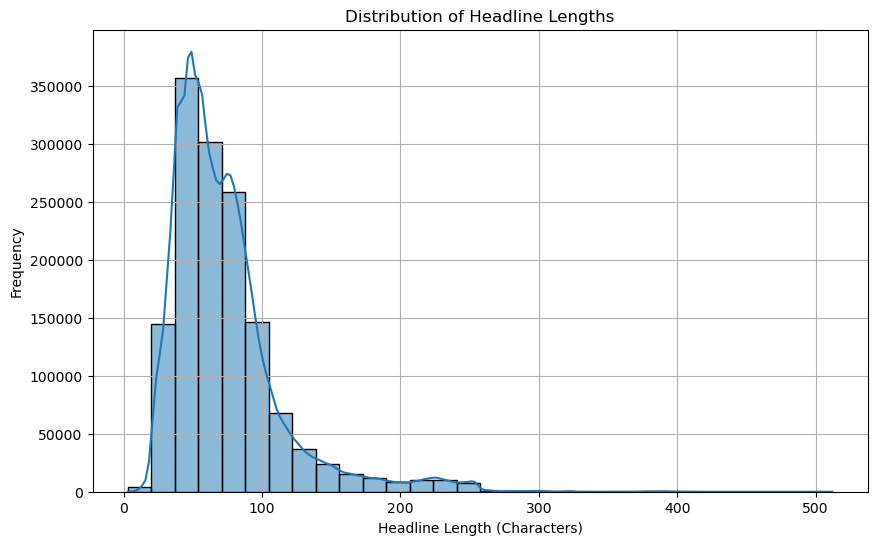

In [5]:
# Display dataset info
print('=== Dataset Overview ===')
print(news_data.info())

# Check for missing values
print('\n=== Missing Values ===')
print(news_data.isnull().sum())

#print(news_data[news_data['date'].isnull()].head(5))
#print(news_data.head())

#df_raw = pd.read_csv('../data/raw_analyst_ratings.csv')
#print(df_raw['date'].dropna().sample(10).tolist())

# Calculate headline length

news_data['headline_length'] = news_data['headline'].apply(len)
print('\n=== Headline Length Statistics ===')
print(news_data['headline_length'].describe())

# Plot headline length distribution
plt.figure(figsize=(10, 6))
sns.histplot(news_data['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length (Characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('../data/processed/headline_length_distribution.png')
plt.show()


### Publisher Analysis

Analyze the distribution of articles by publisher and extract domains from email-based publishers.


=== Top 5 Publishers ===
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64

=== Top 5 Publisher Domains ===
publisher_domain
N/A               1399240
benzinga.com         7937
gmail.com             139
andyswan.com            5
investdiva.com          2
Name: count, dtype: int64


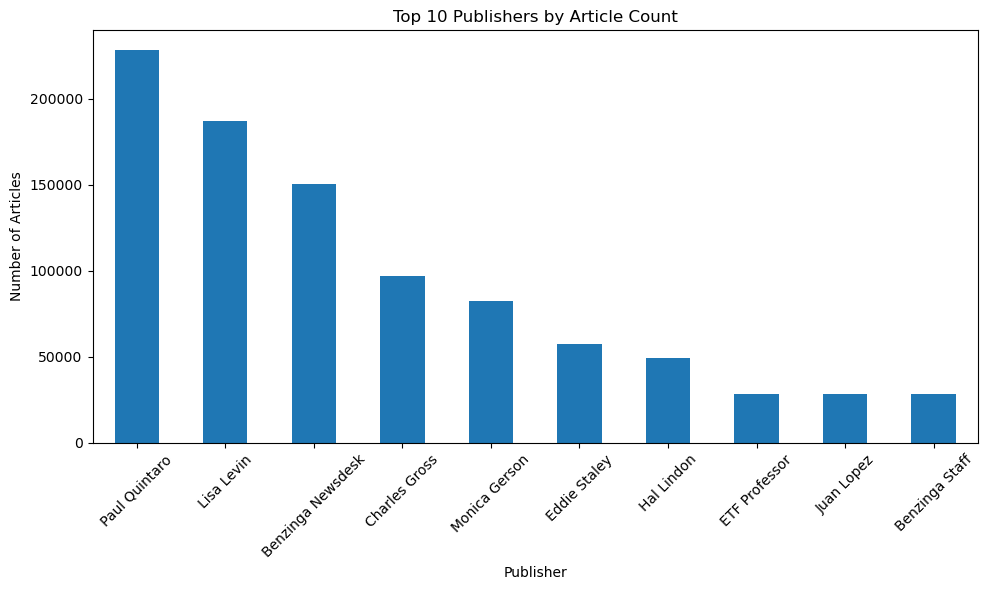

In [20]:
# Function to extract domain from publisher
def extract_domain(publisher):
    """Extract domain from publisher email or return 'N/A' if not an email."""
    if '@' in str(publisher):
        return publisher.split('@')[-1]
    return 'N/A'

# Extract publisher domains
news_data['publisher_domain'] = news_data['publisher'].apply(extract_domain)
publisher_counts = news_data['publisher'].value_counts()
domain_counts = news_data['publisher_domain'].value_counts()

# Display top publishers and domains
print('\n=== Top 5 Publishers ===')
print(publisher_counts.head())
print('\n=== Top 5 Publisher Domains ===')
print(domain_counts.head())

# Plot top publishers
plt.figure(figsize=(10, 6))
publisher_counts[:10].plot(kind='bar')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../data/processed/publisher_distribution.png')
plt.show()

### Time Series Analysis

Analyze publication frequency over time and by hour of the day to identify trends and patterns.

In [ ]:
# Extract date and hour
news_data['date_only'] = news_data['date'].dt.date
news_data['hour'] = news_data['date'].dt.hour

# Daily publication frequency
daily_counts = news_data.groupby('date_only').size()
plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title('Article Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.savefig('../data/processed/publication_frequency.png')
plt.show()

# Hourly publication patterns
hourly_counts = news_data.groupby('hour').size()
plt.figure(figsize=(10, 6))
hourly_counts.plot(kind='bar')
plt.title('Article Publication by Hour of Day (UTC)')
plt.xlabel('Hour')
plt.ylabel('Number of Articles')
plt.grid(axis='y')
plt.savefig('../data/processed/hourly_publication.png')
plt.show()